In [1]:
# this is necessary to be able to import modules from the parent dir
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from colag.colag import hamming_distance, parameters

plt.rcParams['figure.figsize'] = 17, 5

In [3]:
param_nums = ['p{}'.format(p+1) for p in range(13)]

In [4]:
columns = ['target', 'n', 'num_sents', 'learned_lang', 'learned_params']
columns += param_nums
columns += ['empty', 'runtime']

williamfn = '../data/yang_rewrite/OUTDATA_REL20180217-135950.csv'
williamvl = pd.read_csv(williamfn, skiprows=[0], header=None).reset_index(drop=True)
williamvl.columns = columns
williamvl.head(1)

,target,n,num_sents,learned_lang,learned_params,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,empty,runtime
0,611,0,50000,35,'0000000100011,0.000096,3.297047e-07,0.000811,0.632259,0.005492,0.000021,0.51829,0.848335,0.00001,0.003794,0.019531,0.587129,0.996586,NaN,0:00:00.354175


In [5]:
columns = ['learner', 'target', 'n', 'num_sents', 'learned_lang']
columns += ['p{}'.format(p+1) for p in range(13)]
columns += ['empty', 'runtime']
paulvl = pd.read_csv('../data/yang_rewrite/vl-comparison.txt', delimiter='\t', index_col=None, header=None)
paulvl.reset_index(drop=True)
paulvl.columns = columns
paulvl.head(1)

,learner,target,n,num_sents,learned_lang,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,empty,runtime
0,RewardOnlyLearner,611,0,50000,33,0.00049,6.304575e-07,0.000689,0.511406,0.000208,0.000559,0.509303,0.839233,0.000045,0.010926,0.016844,0.523674,0.995006,NaN,0:00:00.202217


# Does the new VL implementation match the old?



In [13]:
paul_reward_only = paulvl[paulvl.learner.eq('RewardOnlyLearner')]
william_reward_only = williamvl

# narrow to common columns
paul_reward_only = paul_reward_only[[c for c in paul_reward_only.columns 
                                     if c in william_reward_only.columns]]
william_reward_only = william_reward_only[[c for c in william_reward_only.columns 
                                           if c in paul_reward_only.columns]]
paul_reward_only['source'] = 'paul'
william_reward_only['source'] = 'william'
df = pd.concat([paul_reward_only, william_reward_only])
df = df.reset_index(drop=True)
df.head(2)

,target,n,num_sents,learned_lang,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,empty,runtime,source
0,611,0,50000,33,0.000490,6.304575e-07,0.000689,0.511406,0.000208,0.000559,0.509303,0.839233,0.000045,0.010926,0.016844,0.523674,0.995006,NaN,0:00:00.202217,paul
1,611,1,50000,609,0.000099,7.342163e-07,0.000128,0.609433,0.000257,0.000043,0.508959,0.820873,0.000018,0.019050,0.022072,0.465168,0.991197,NaN,0:00:00.074757,paul


For each language, we both ran 100 learners on 50,000 input sentences.

In [20]:
williamvl.groupby(['target']).size()

target
584     100
611     100
2253    100
3856    100
dtype: int64

In [22]:
williamvl.num_sents.value_counts()

50000    400
Name: num_sents, dtype: int64

In [17]:
paulvl.groupby(['learner', 'target']).size()

learner                     target
RelevantRewardOnlyLearner   584       100
                            611       100
                            2253      100
                            3856      100
RewardOnlyLearner           584       100
                            611       100
                            2253      100
                            3856      100
SkepticalRewardOnlyLearner  584       100
                            611       100
                            2253      100
                            3856      100
dtype: int64

In [19]:
paulvl.num_sents.value_counts()

50000    1200
Name: num_sents, dtype: int64

## Comparing mean hamming distances

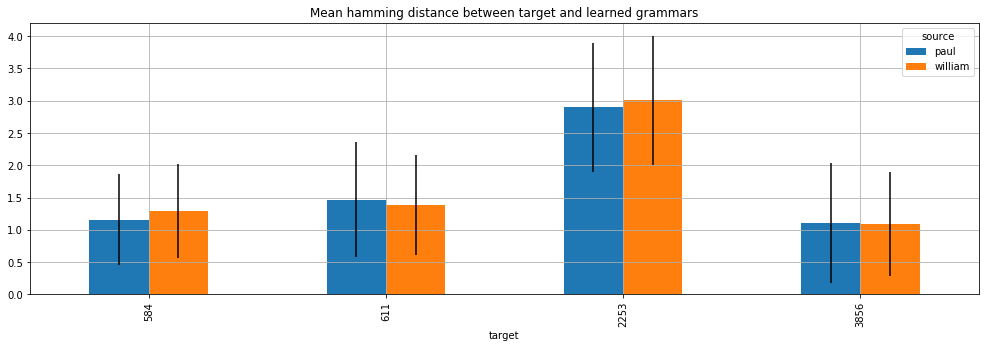

In [7]:
df['distance'] = df.apply(lambda x: hamming_distance(x.target, x.learned_lang), axis=1)
(
    df.groupby(['target', 'source'])
    .distance.agg(['mean', 'std'])
    .unstack()
    .plot.bar(y='mean', yerr='std', grid=True, title='Mean hamming distance between target and learned grammars')
);

## Comparing trigger weight vectors between paul & william VL

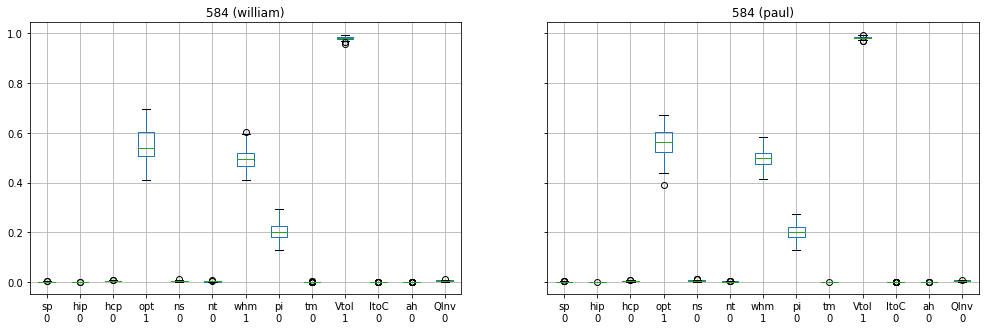

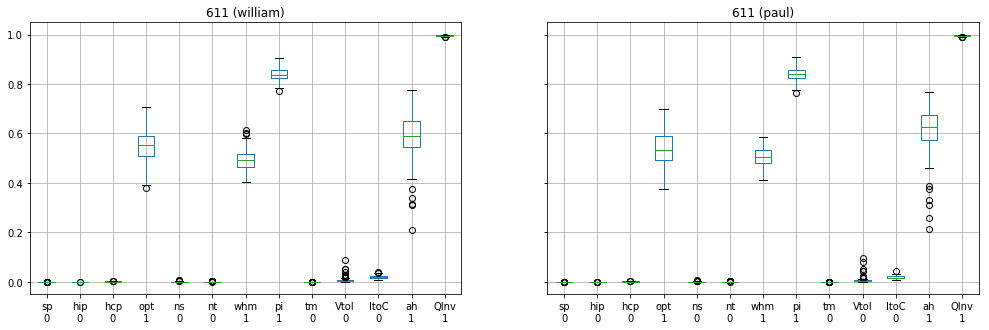

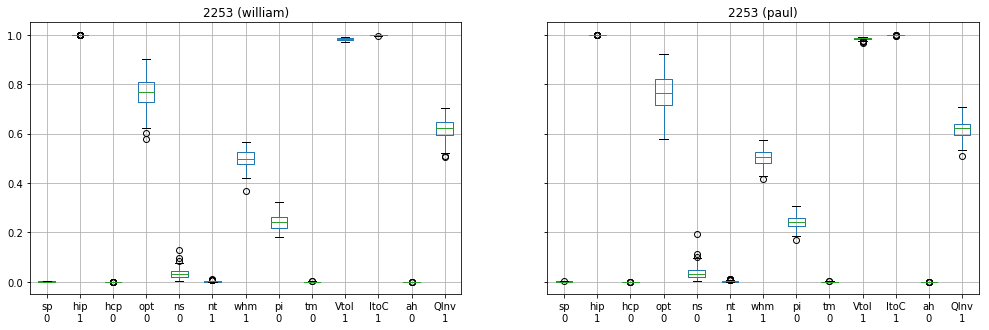

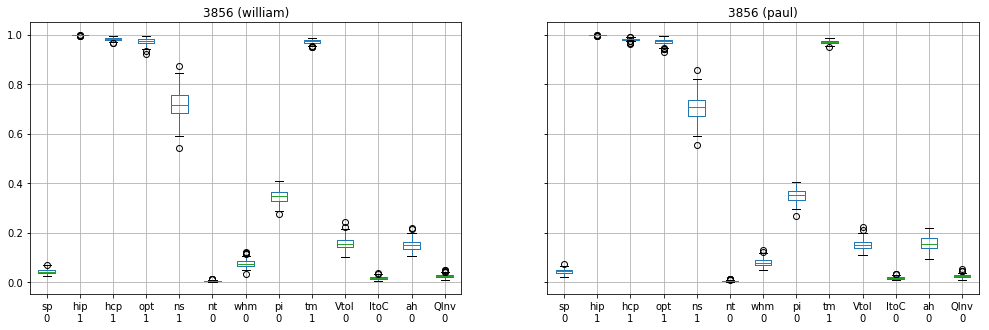

In [8]:
for key, group in df.groupby(['target']).groups.items():
    fig, (ax, ax2) = plt.subplots(ncols=2, sharey=True)

    data = df.loc[group][['source'] + param_nums]
    
    w = data[data.source.eq('william')]
    w.plot.box(title='{} (william)'.format(key), ax=ax, grid=True)
   
    p = data[data.source.eq('paul')]
    p.plot.box(ax=ax2, title='%s (paul)' % key, grid=True)
    
    for a in [ax, ax2]:
        a.set_xticklabels(['{}\n{}'.format(p, bit) 
                       for p, bit in zip(parameters,'{:013b}'.format(key))])

# Comparing Augmented VLs

In [9]:
paulvl['distance'] = paulvl.apply(lambda x: hamming_distance(x.target, x.learned_lang), axis=1)

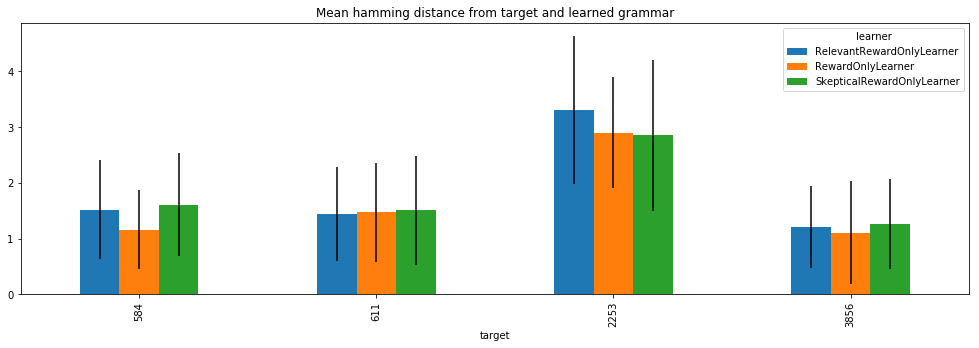

In [10]:
(
    paulvl.groupby(['target', 'learner'])
    .distance.agg(['mean', 'std'])
    .unstack()
    .plot.bar(y='mean', yerr='std', title='Mean hamming distance from target and learned grammar')
);

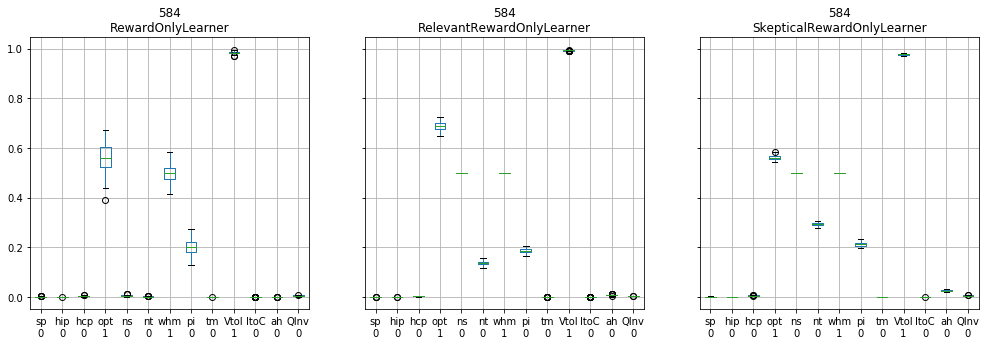

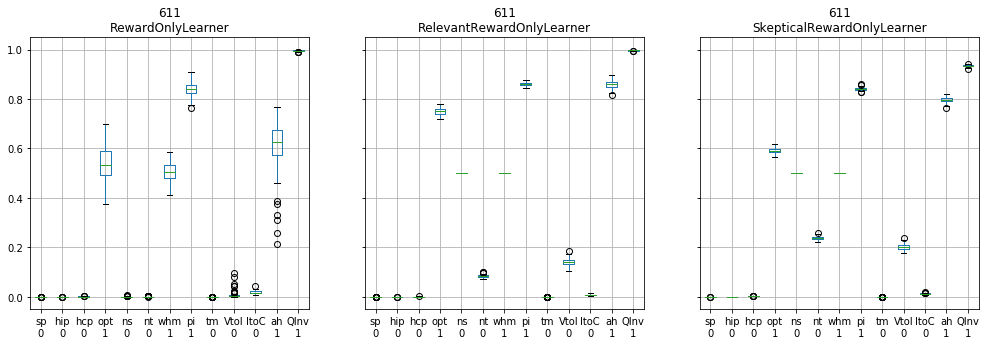

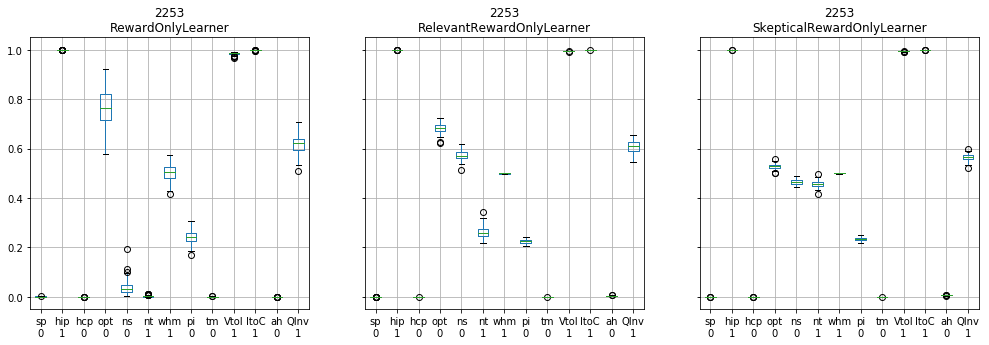

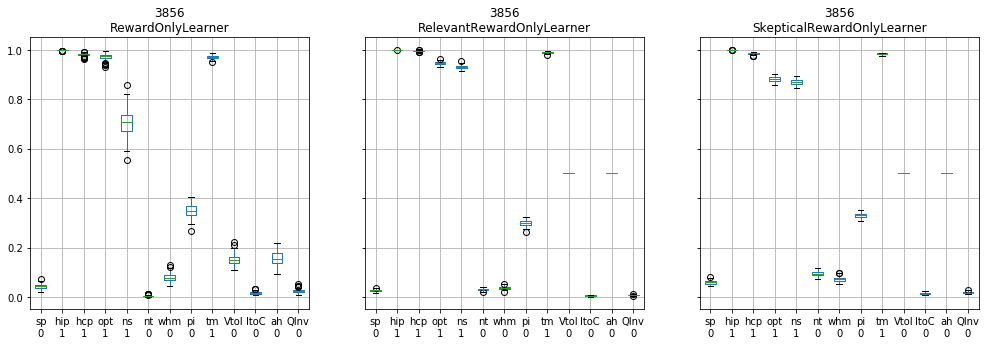

In [11]:
for key, group in paulvl.groupby(['target']).groups.items():
    fig, (ax, ax2, ax3) = plt.subplots(ncols=3, sharey=True)
    data = paulvl.loc[group]
    for learner, axis in zip(paulvl.learner.unique(), [ax, ax2, ax3]):
        data[data.learner.eq(learner)][param_nums].plot.box(ax=axis, title='%s\n%s' % (key, learner), grid=True);

    for a in [ax, ax2, ax3]:
        a.set_xticklabels(['{}\n{}'.format(p, bit) 
                       for p, bit in zip(parameters,'{:013b}'.format(key))])